In [3]:
%reset
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import time

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [117]:
thre = 1.2

class Problem():
    
    def __init__(self, p_start=None, p_end=None, ncontrols=2):
        
        if p_start is None:
            p_start = -np.ones(2) * 9
        self.p_start = p_start
        
        if p_end is None:
            p_end = np.ones(2) * 9
        self.p_end = p_end
        
        self.h = 0.01
        self.nsamples = 101
        
        self.ncontrols = ncontrols
        
        self.scale_L0 = 1e4
        self.scale_L1 = 1e3
        self.scale_L2 = 1e2
        self.scale_L3 = 1
        
        self.max_deriv = 1e32
        
        self.cond_info = {}
        
    def safe_division(self, a, b):
        ans = a / b
        ans[b == 0] = 0
        return ans
    
    def get_l0(self, pos):
        x = pos[..., 0]
        y = pos[..., 1]
        
        cond_diff = (x ** 2 + y ** 2) / 4000 - np.cos(x) * np.cos(y / 2 ** 0.5) + 1
        
        cond = cond_diff > thre
        
        left = self.scale_L0
        right = 0
        
        ans = right + left * cond.astype('f')
        
        self.cond_info['l0'] = (cond, cond_diff, left, right)
        
        return ans
    
    def get_partial_l0(self, pos, dl0, forward=False):
        
        # l0 and dl0: nsamples X ncontrols
        # partial_l0_cond_diff: nsamples X ncontrols
        # pos and dpos: nsamples X ncontrols X 2
        
        if forward:
            self.get_l0(pos)
        
        cond, cond_diff, left, right = self.cond_info['l0']
        
        partial_cond_diff_coord = cond_diff[1:] - cond_diff[:-1]
        
        cond_scale = cond[1:].astype(int) - cond[:-1].astype(int)
        
        l0_scale = (left - right) * cond_scale
        
        partial_l0_cond_diff_raw = self.safe_division(l0_scale, partial_cond_diff_coord)
        
        partial_l0_cond_diff = np.zeros(cond_diff.shape)
        
        partial_l0_cond_diff[1:] += partial_l0_cond_diff_raw
        partial_l0_cond_diff[:-1] += partial_l0_cond_diff_raw
        partial_l0_cond_diff *= 0.5
        
        dcond_diff = dl0 * partial_l0_cond_diff
        
        x = pos[..., 0]
        y = pos[..., 1]
        
        partial_cond_diff_x = 2 * x / 4000 + np.cos(y / 2 ** 0.5) * np.sin(x)
        partial_cond_diff_y = 2 * y / 4000 + np.cos(x) * np.sin(y / 2 ** 0.5) / 2 ** 0.5
        
        partial_cond_diff_pos = np.stack((partial_cond_diff_x, partial_cond_diff_y), -1)
        
        dpos = np.expand_dims(dcond_diff, -1) * partial_cond_diff_pos
        
        return dpos
    
    def get_vp_base(self, par):
        
        ax = par[:self.ncontrols]
        ay = par[self.ncontrols:self.ncontrols*2]
        dt = par[self.ncontrols*2:]
        
        dvx = ax * dt
        vx = np.cumsum(dvx)
        extended_vx = np.concatenate(([0], vx), 0)
        
        dvy = ay * dt
        vy = np.cumsum(dvy)
        extended_vy = np.concatenate(([0], vy), 0)
        
        dpx = 0.5 * ax * dt ** 2 + extended_vx[:-1] * dt
        px = np.cumsum(dpx) + self.p_start[0]
        
        dpy = 0.5 * ay * dt ** 2 + extended_vy[:-1] * dt
        py = np.cumsum(dpy) + self.p_start[1]
        
        return np.stack([vx, vy], -1), np.stack([px, py], -1)
    
    def get_partial_vp_base(self, par, dv_base, dp_base):
        
        # v_base and cv_base: ncontrols X 2
        # p_base and dp_base: ncontrols X 2
        
        ax = par[:self.ncontrols]
        ay = par[self.ncontrols:self.ncontrols*2]
        dt = par[self.ncontrols*2:]
        
        dvx = ax * dt
        vx = np.cumsum(dvx)
        extended_vx = np.concatenate(([0], vx), 0)
        
        dvy = ay * dt
        vy = np.cumsum(dvy)
        extended_vy = np.concatenate(([0], vy), 0)
        
        dpx = dp_base[..., 0].copy()
        dpy = dp_base[..., 1].copy()
        
        ddpx = np.cumsum(dpx[::-1])[::-1]
        ddpy = np.cumsum(dpy[::-1])[::-1]
        
        dax = ddpx * 0.5 * dt ** 2
        day = ddpy * 0.5 * dt ** 2
        
        ddt = ddpx * (ax * dt + extended_vx[:-1]) + ddpy * (ay * dt + extended_vy[:-1])
        
        dvx = dv_base[..., 0].copy()
        dvx[:-1] += (ddpx * dt)[1:]
        
        dvy = dv_base[..., 1].copy()
        dvy[:-1] += (ddpy * dt)[1:]
        
        ddvx = np.cumsum(dvx[::-1])[::-1]
        ddvy = np.cumsum(dvy[::-1])[::-1]
        
        dax += ddvx * dt
        day += ddvy * dt
        
        ddt += ddvx * ax + ddvy * ay
        
        return np.concatenate((dax, day, ddt), 0)
    
    def get_vp(self, par, v_base, p_base):
        
        ax = np.expand_dims(par[:self.ncontrols], (0, -1))
        ay = np.expand_dims(par[self.ncontrols:self.ncontrols*2], (0, -1))
        acc = np.concatenate((ax, ay), -1)
        
        # 3D tensor, nsamples x ncontrols x 2 (last dimension representing we are on a 2D plane)
        taus = np.tile(np.expand_dims(np.linspace(0, 1, self.nsamples), -1), [1, self.ncontrols])
        taus = np.expand_dims(taus, -1)
        
        init_v = np.concatenate((np.zeros((1, 2)), v_base[:-1]), 0)
        init_p = np.concatenate((np.expand_dims(self.p_start, 0), p_base[:-1]), 0)
        
        init_v = np.expand_dims(init_v, 0)
        init_p = np.expand_dims(init_p, 0)
        
        dt = np.expand_dims(par[self.ncontrols*2:], (0, -1))
        taus *= dt
        
        vel = acc * taus + init_v
        pos = 0.5 * acc * taus ** 2 + init_v * taus + init_p

        return vel, pos
    
    def get_partial_vp(self, par, v_base, p_base, dvel, dpos):
        # returns: partial_pos_par, partial_pos_v_base, partial_pos_p_base
        
        # pos and dpos: nsamples X ncontrols X 2
        # acc and dacc: ncontrols X 2
        # dt and ddt: ncontrols
        # init_v and dinit_v: ncontrols X 2
        # init_p and dinit_p: ncontrols X 2
        # taus and dtaus: nsamples X ncontrols
        # v_base and dv_base: ncontrols X 2
        # p_base and dp_base: ncontrols X 2
        
        
        # partial_pos_p_base: nsamples X ncontrols X 1
        # dp_base: ncontrols X 2
        # partial_pos_taus: nsamples X ncontrols X 2
        # dtau: nsamples x ncontrols
        # partial_pos_current_dt: nsamples X ncontrols X 2
        # ddt: ncontrols

        taus_orig = np.tile(np.expand_dims(np.linspace(0, 1, self.nsamples), -1), [1, self.ncontrols])
        taus_orig = np.expand_dims(taus_orig, -1)
        
        current_dt = np.expand_dims(par[self.ncontrols*2:], (0, -1))
        taus = taus_orig * current_dt
        
        ax = np.expand_dims(par[:self.ncontrols], (0, -1))
        ay = np.expand_dims(par[self.ncontrols:self.ncontrols*2], (0, -1))
        acc = np.concatenate((ax, ay), -1)
        
        init_v = np.concatenate((np.zeros((1, 2)), v_base[:-1]), 0)
        init_p = np.concatenate((np.expand_dims(self.p_start, 0), p_base[:-1]), 0)
        
        init_v = np.expand_dims(init_v, 0)
        init_p = np.expand_dims(init_p, 0)
        
        dacc = (dpos * 0.5 * taus ** 2).sum(0)
        dinit_v = (dpos * taus).sum(0)
        dinit_p = dpos.sum(0)
        dtaus = (dpos * (acc * taus + init_v)).sum(-1)
        
        dacc += (dvel * taus).sum(0)
        dinit_v += (dvel).sum(0)
        dtaus += (dvel * acc).sum(-1)
        
        ddt = (dtaus * taus_orig[..., 0]).sum(0)
        dp_base = np.concatenate((dinit_p[1:], np.zeros((1, 2))))
        dv_base = np.concatenate((dinit_v[1:], np.zeros((1, 2))))
        
        dpar = np.concatenate((dacc[:, 0], dacc[:, 1], ddt))
        
        return dpar, dv_base, dp_base
    
    def get_L0(self, par, v_base, p_base, get_deriv=False, method='ours'):
        
        dt = par[self.ncontrols*2:]
        
        vel, pos = self.get_vp(par, v_base, p_base)
        l0_vals = self.get_l0(pos)
        
        v_norm = (vel ** 2).sum(-1) ** 0.5
        int_vals = l0_vals * v_norm
        
        L0_raw = int_vals.sum(0) - 0.5 * (int_vals[0] + int_vals[-1])
        L0 = L0_raw / (self.nsamples - 1)
        
        scaled_L0 = L0 * dt
        
        ans = scaled_L0.sum()
        
        if get_deriv:
            
            # L0: ncontrols
            # dt: ncontrols
            # int_vals and l0_vals: nsamples X ncontrols
            # vel and pos: nsamples X ncontrols X 2
            # v_norm: nsamples X ncontrols
            
            partial_ans_L0_raw = dt / (self.nsamples - 1)
            
            partial_ans_dt = L0
            
            partial_ans_int_vals = np.ones(int_vals.shape) * np.expand_dims(partial_ans_L0_raw, 0)
            partial_ans_int_vals[0] *= 0.5
            partial_ans_int_vals[-1] *= 0.5

            if True:
                partial_ans_l0_vals = partial_ans_int_vals * v_norm

                if method == 'ours':
                    partial_ans_pos = self.get_partial_l0(pos, partial_ans_l0_vals)
                else:
                    assert method == 'AD'
                    partial_ans_pos = np.zeros(pos.shape)
                
            if True:
                partial_ans_v_norm = partial_ans_int_vals * l0_vals
                
                partial_ans_vel = np.expand_dims(self.safe_division(partial_ans_v_norm, v_norm), -1) * vel
                
            partial_ans_par, partial_ans_v_base, partial_ans_p_base = \
            self.get_partial_vp(par, v_base, p_base, partial_ans_vel, partial_ans_pos)
            
            partial_ans_par[self.ncontrols*2:] += partial_ans_dt
            
            return partial_ans_par, partial_ans_v_base, partial_ans_p_base
        
        return ans
    
    def get_L0_num(self, par, v_base, p_base):
        
        ax = par[:self.ncontrols]
        ay = par[self.ncontrols:self.ncontrols*2]
        acc = np.concatenate((ax, ay), -1)
        
        dt = par[self.ncontrols*2:]
        
        init_v = np.concatenate((np.zeros((1, 2)), v_base[:-1]), 0)
        init_p = np.concatenate((np.expand_dims(self.p_start, 0), p_base[:-1]), 0)
        
        ans = 0
        
        for idx in range(self.ncontrols):
            def func(t):
                vel = acc[idx] * t + init_v[idx]
                pos = 0.5 * acc[idx] * t ** 2 + init_v[idx] * t + init_p[idx]
                
                return self.get_l0(pos) * ((vel ** 2).sum() ** 0.5)
            
            ans += integrate.quad(func, 0, dt[idx])[0]
            
        return ans
    
    def get_L1(self, p_base):
        
        diff = ((p_base[-1] - self.p_end) ** 2).sum()
        
        diff *= self.scale_L1
        
        return diff
    
    def get_partial_L1(self, p_base):
        
        dL1_p_base_last = 2 * (p_base[-1] - self.p_end) * self.scale_L1
        
        dL1_p_base = np.concatenate((np.zeros((self.ncontrols-1, 2)), np.expand_dims(dL1_p_base_last, 0)), 0)
        
        return dL1_p_base
    
    def get_L2_old(self, par):
        
        dt = par[self.ncontrols*2:]
        
        loss = -np.log(dt).sum() * self.scale_L2
        
        return loss
    
    def get_partial_L2_old(self, par):
        
        dt = par[self.ncontrols*2:]
        
        dL2_dt = -1 / dt * self.scale_L2
        
        return dL2_dt
    
    def get_L2(self, par):
        
        dt = par[self.ncontrols*2:]
        
        loss = np.exp(-2 * dt * self.scale_L2) / (np.exp(-dt * self.scale_L2) + 1)
        
        return loss.sum()
    
    def get_partial_L2(self, par):
        
        dt = par[self.ncontrols*2:]
        
        T = -2 * dt * self.scale_L2
        
        dL2_dT = np.exp(2 * T) * (2 + np.exp(T)) / (1 + np.exp(T)) ** 2
        
        dL2_dt = dL2_dT * (-2 * self.scale_L2)
        
        return dL2_dt
    
    def get_L3(self, par):
        """
        L3 tries to minimize the amount or propellant used
        According to wikipedia
        https://en.wikipedia.org/wiki/Specific_impulse
        F_thrust = g * I_sp * dm/dt
        where g is gravity, I_sp is specific impulse, and dm/dt is the speed where propellant is used
        For a specific robot / rocket / vehicle, we can assume g and I_sp are fixed
        Therefore, minimizing m is equivalent to minimizing
        integrate(||F||dt)
        """
        ax = par[:self.ncontrols]
        ay = par[self.ncontrols:self.ncontrols*2]
        
        dt = par[self.ncontrols*2:]
        
        F = (ax ** 2 + ay ** 2) ** 0.5

        loss = (F * dt) * self.scale_L3
        
        return loss.sum()
    
    def get_partial_L3(self, par):
        ax = par[:self.ncontrols]
        ay = par[self.ncontrols:self.ncontrols*2]
        
        dt = par[self.ncontrols*2:]
        
        F = (ax ** 2 + ay ** 2) ** 0.5
        
        dL3_dt = self.scale_L3 * F
        dL3_dF = self.scale_L3 * dt
        
        dF_dax = ax / F
        dF_day = ay / F
        
        return np.concatenate((dL3_dF * dF_dax,
                               dL3_dF * dF_day,
                               dL3_dt))
    
    def get_loss(self, par, verbose=False, method='sample', exclude_constrain=False):
        v_base, p_base = self.get_vp_base(par)
        
        if method == 'sample':
            L0 = self.get_L0(par, v_base, p_base)
        else:
            L0 = self.get_L0_num(par, v_base, p_base)
        L1 = self.get_L1(p_base)
        
        L2 = self.get_L2(par)
        
        L3 = self.get_L3(par)
        
        if verbose:
            print('L0:', L0)
            print('L1:', L1)
            print('L2:', L2)
            print('L3:', L3)
        
        if exclude_constrain:
            return L0 + L1 + L3
        else:
            return L0 + L1 + L2 + L3
    
    def get_dL(self, par, method='ours'):
        
        v_base, p_base = self.get_vp_base(par)
        
        partial_L0_par, partial_L0_v_base, partial_L0_p_base = \
        self.get_L0(par, v_base, p_base, True, method=method)
        
        partial_L1_p_base = self.get_partial_L1(p_base)
        
        partial_L2_dt = self.get_partial_L2(par)
        
        partial_L_v_base = partial_L0_v_base
        partial_L_p_base = partial_L0_p_base + partial_L1_p_base
        
        partial_L_par = self.get_partial_vp_base(par, partial_L_v_base, partial_L_p_base)
        partial_L_par += partial_L0_par
        partial_L_par[self.ncontrols*2:] += partial_L2_dt
        
        partial_L_par += self.get_partial_L3(par)
        
        # avoid numerical instability
        return np.clip(partial_L_par, -self.max_deriv, self.max_deriv)
    
    def get_FD(self, func, par, df=None):
        
        ans = func(par)
        
        if isinstance(ans, np.ndarray):
            assert df is not None and ans.shape == df.shape
            
            new_func = lambda x: (func(x) * df).sum()
        else:
            new_func = func
        
        par_flat = par.flatten()
        deriv = np.zeros(par_flat.shape)
        
        offset = np.zeros(par_flat.shape)
        
        for idx in range(par_flat.shape[0]):
            offset[:] = 0
            
            offset[idx] = self.h
            val_pos = new_func((par_flat + offset).reshape(par.shape))
            
            offset[idx] = -self.h
            val_neg = new_func((par_flat + offset).reshape(par.shape))
            
            deriv[idx] = (val_pos - val_neg) / (2 * self.h)
            
        return deriv.reshape(par.shape)

In [118]:
pb = Problem(ncontrols=10)
par = np.array([0.17656213 , 0.66217699 , 0.19726729  ,1.27337773 , 0.8279505 ,  0.34808971,
  0.20107724 , 2.19185607 , 1.14482065 , 0.92206658  ,1.07822515  ,1.14978921,
  0.43376487 , 0.94993489, -0.13452347 , 1.32304535 , 0.37668559 , 1.345029,
  0.68035395 , 1.09623449  ,1.83708227 , 4.54321075 , 6.6806026 ,  4.50251111,
  8.76826264 , 2.30331189 , 9.05510717 , 1.22166101 , 6.02413095 , 6.28579193])

v_base, p_base = pb.get_vp_base(par)
vel, pos = pb.get_vp(par, v_base, p_base)

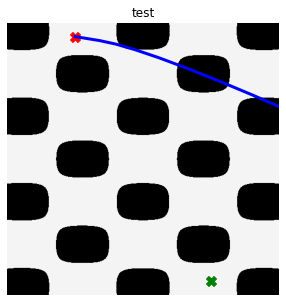

In [132]:
def draw_path(par, pb, title=None, scatter=False, idx=None, savename=None):
    
    xmin = -10
    xmax = 10
    ymin = -10
    ymax = 10
    
    fig = plt.figure(figsize=(5, 5))
    
    x, y = np.meshgrid(np.linspace(xmin, xmax, 500), np.linspace(ymin, ymax, 500), indexing='ij')
    
    cond_diff = (x ** 2 + y ** 2) / 4000 - np.cos(x) * np.cos(y / 2 ** 0.5) + 1
        
    cond = cond_diff > thre
    
    img = cond.astype('f')
        
    plt.imshow(img, extent=[xmin, xmax, ymax, ymin], cmap='Greys', vmin=-0.1)
    
    plt.scatter(pb.p_start[1], pb.p_start[0], marker='X', s=100, c='red')
    plt.scatter(pb.p_end[1], pb.p_end[0], marker='X', s=100, c='green')

    v_base, p_base = pb.get_vp_base(par)
    vel, pos = pb.get_vp(par, v_base, p_base)
    
    if idx is None:
        yy = pos[..., 1]
        xx = pos[..., 0]
    else:
        yy = pos[..., idx, 1]
        xx = pos[..., idx, 0]

    if scatter:
        plt.scatter(yy.transpose().flatten(), xx.transpose().flatten(), s=1)
    else:
        plt.plot(yy.transpose().flatten(), xx.transpose().flatten(), linewidth=3, c='blue')
        
    
        
    if title is not None:
        plt.title(title)
        
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    
    plt.axis('off')
        
    plt.gca().invert_yaxis()
    
    if savename is not None:
        plt.savefig(savename, bbox_inches='tight')
    else:
        plt.show()
    plt.close()
    
draw_path(par, pb, 'test')

In [120]:
print('L sample:', pb.get_loss(par, True, 'sample'))
print('L num:', pb.get_loss(par, True, 'num'))

L0: 11046466.84240899
L1: 1223047999.6700594
L2: 7.724545223935438e-107
L3: 52.91242983209748
L sample: 1234094519.4248981
L0: 11208914.93855116
L1: 1223047999.6700594
L2: 7.724545223935438e-107
L3: 52.91242983209748
L num: 1234256967.5210404


/n/fs/shaderml/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [121]:
class AdamOptim():
    """
    Code adapted from
    https://towardsdatascience.com/how-to-implement-an-adam-optimizer-from-scratch-76e7b217f1cc
    and
    https://github.com/halide/Halide/blob/master/src/autoschedulers/adams2019/cost_model_generator.cpp#L48
    """
    def __init__(self, eta=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m = 0
        self.v = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
        self.t = 1
        
    def reset(self, eta=None):
        self.m = 0
        self.v = 0
        self.t = 1
        
        if eta is not None:
            self.eta = eta
    
    def update(self, val, grad):
        ## momentum 
        self.m = self.beta1*self.m + (1-self.beta1)*grad

        ## rms beta 2
        self.v = self.beta2*self.v + (1-self.beta2)*(grad**2)

        ## bias correction
        m_corr = self.m/(1-self.beta1**self.t)
        v_corr = self.v/(1-self.beta2**self.t)

        ## update weights and biases
        val -= self.eta*(m_corr / (np.sqrt(v_corr) + self.epsilon))
        
        self.t += 1
        
        return val

In [122]:
ncontrols = 10

pb = Problem(ncontrols=ncontrols, p_start=np.array([-9, -5]), p_end=np.array([9, 5]))

methods = ['num', 'ours', 'AD', 'FD']

data = {}

for method in methods:
    
    data[method] = {}
    
    if method == 'num':
        data[method]['S_func'] = lambda x: pb.get_loss(x, exclude_constrain=True)
        data[method]['dS_func'] = lambda y: pb.get_FD(lambda x: pb.get_loss(x, method='num'), y)
    else:
        data[method]['S_func'] = lambda x: pb.get_loss(x, exclude_constrain=True)
        if method == 'ours':
            data[method]['dS_func'] = pb.get_dL
        elif method == 'AD':
            data[method]['dS_func'] = lambda x: pb.get_dL(x, method='AD')
        else:
            data[method]['dS_func'] = lambda x: pb.get_FD(pb.get_loss, x)

[0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.  ]


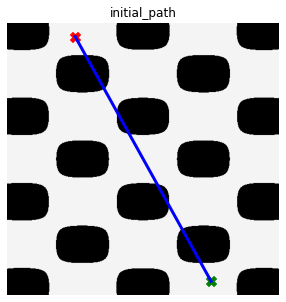

In [134]:
def get_init(ncontrols, pb):
    init = np.zeros(3 * ncontrols)
    
    disp = pb.p_end - pb.p_start
    
    # assume 1s per control period
    vel = disp / ncontrols
    
    acc = vel / ncontrols * 2
    
    init[:ncontrols] = acc[0]
    init[ncontrols:2*ncontrols] = acc[1]
    init[2 * ncontrols:] = 1
    
    #init[:2 * ncontrols] += np.random.rand(ncontrols * 2) * 0.1 - 0.05

    return init
    
init = get_init(ncontrols, pb)
print(init)
    
draw_path(init, pb, 'initial_path')
draw_path(init, pb, savename='init')

[0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.  ]


/n/fs/shaderml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


8.656534344797032
[ 0.02402433  0.19120565  0.36059521  0.57191675  0.75207558  0.56656477
  0.21375946 -0.29360334 -0.75115099  0.67382577  0.48305995  0.27854196
  0.06092011 -0.18847929 -0.4521271  -0.2308374   0.06064717  0.71810166
  1.6066618  -0.25302274  1.15396045  0.96951745  0.87445355  1.02542283
  1.38756727  1.16986342  1.04472026  0.94284142  1.77347401  1.09933225]
time per iter:  0.0010481777985890707


/n/fs/shaderml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


25297.2142939967
[ 1.49110025e-01 -3.47947084e+00  2.96276053e-01  6.38898295e-01
  9.77631338e-01  1.28504003e+00  1.27187396e+00  2.80856717e+00
 -9.57952412e-01 -3.81372200e-01  7.72254505e-02 -2.00567221e+00
  9.97242936e-02  3.40611883e-01  5.96132672e-01  5.79664100e-01
  6.07992840e-01  1.60568968e+00 -1.00031654e+00 -4.55939554e-01
  4.60217277e+00  4.34156493e-01 -2.00772789e-02 -2.09044971e-02
 -1.81342645e-02 -1.78398429e-02 -1.97296526e-02  3.67179074e+00
 -7.81234057e-03  4.05778536e-04]
time per iter:  0.0009366425275802613
22564.908297888833
[ 1.66599470e+00  4.45863288e-02  1.25704722e+00  1.22790887e+00
  8.11794067e-01  8.05771012e-01  9.43898114e-01  1.34844305e+00
  2.22183521e+00  2.15185956e+01 -1.27044032e-01  1.68952186e+00
 -5.87429651e-01 -1.36225664e+00 -7.99900668e-01 -7.51864942e-01
 -8.61962052e-01 -1.46304661e+00 -2.98826797e+00 -2.41078930e+01
  1.60575870e+00  3.31973114e+00  1.09598672e-01  4.30366060e-01
  2.41366204e-02  2.40868513e-02  2.41609766e-0

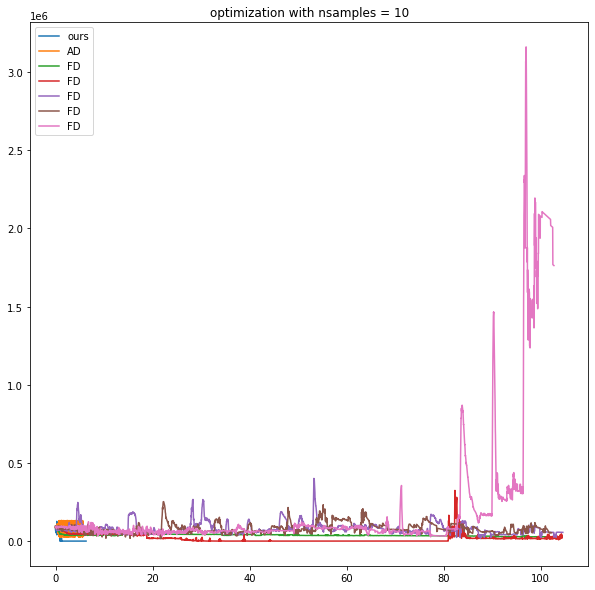

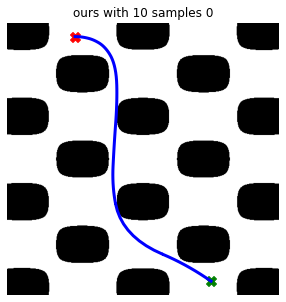

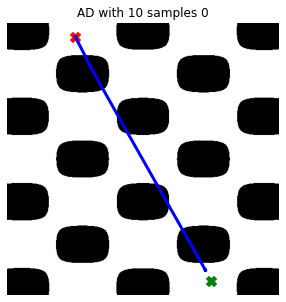

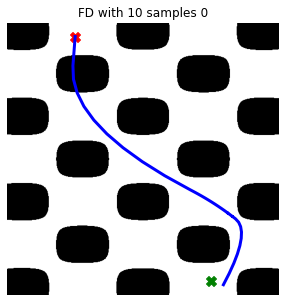

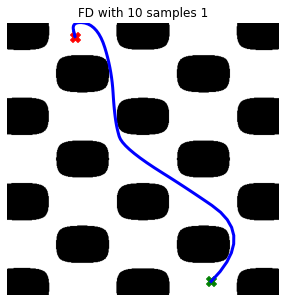

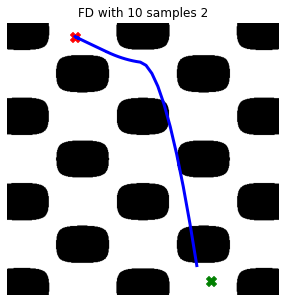

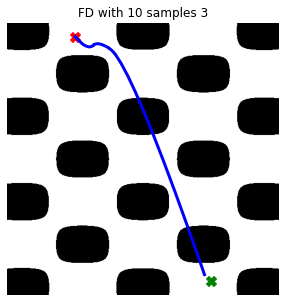

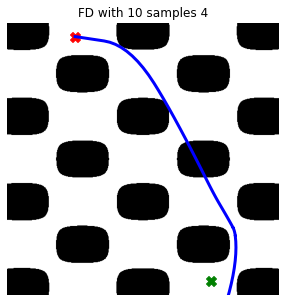

In [124]:
max_iter = 6000

methods = ['ours', 'AD', 'FD']

nsamples = 10

pb.nsamples = nsamples


opt = AdamOptim(eta=0.01)


final_par = {method: [] for method in methods}

for _ in range(1):
    
    init = get_init(ncontrols, pb)
    
    #init = np.array([ 1.62404355 , 0.03060116, -0.09021045 ,-0.1759207  ,-0.26920948  ,0.07499932,
  #0.37864684,  0.67234036,  1.0405928 ,  1.42134028 , 1.21386781, -0.02768536,
  #0.26718313 , 0.44744692 , 0.60247035 , 0.5233411   ,0.019864   ,-0.49680694,
 #-0.87471915 ,-2.50090419  ,0.72180981  ,0.73120065 ,-0.0078835   ,0.75375676,
  #1.20400925  ,1.3024886   ,1.05582614  ,1.10954968  ,1.01698536  ,2.01806094])
    
    print(init)

    opt.reset()
    
    plt.figure(figsize=(10, 10))

    for method in methods:
        
        if method == 'FD':
            nsteps = 5
        else:
            nsteps = 1
            
        for n in range(nsteps):
            
            if method == 'FD':
                pb.h = 0.1 ** (n + 1)
        
            convergence = np.zeros(max_iter)
            val = init.copy()
            opt.reset()

            min_loss_val = 1e8
            min_loss_par = None

            T0 = time.time()

            for idx in range(max_iter):
                deriv = data[method]['dS_func'](val)

                if np.isnan(deriv).sum():
                    raise

                val = opt.update(val, deriv)



                convergence[idx] = data['ours']['S_func'](val)

                if convergence[idx] < min_loss_val:
                    min_loss_val = convergence[idx]
                    min_loss_par = np.copy(val)

            T1 = time.time()

            t_per_iter = (T1 - T0) / max_iter

            print(min_loss_val)
            print(min_loss_par)

            print('time per iter: ', t_per_iter)

            final_par[method].append([min_loss_par, convergence, t_per_iter])

            plt.plot(np.arange(max_iter) * t_per_iter, convergence, label=method)

        
    plt.legend()
    plt.title('optimization with nsamples = %d' % nsamples)
    plt.show()

for method in methods:
    for n in range(len(final_par[method])):
        draw_path(final_par[method][n][0], pb, '%s with %d samples %d' % (method, nsamples, n))


time per iter for ours: 0.001048
time per iter for AD: 0.000937
time per iter for FD: 0.017404


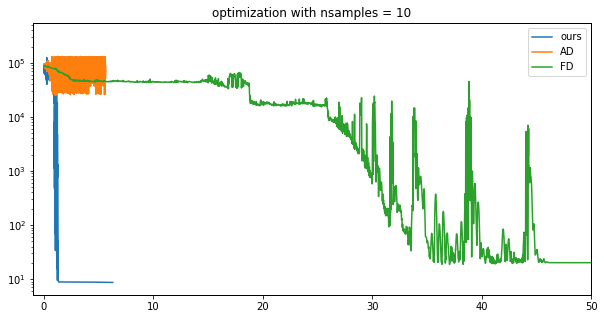

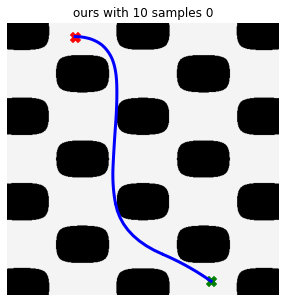

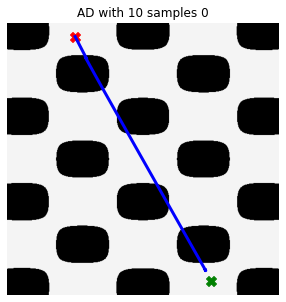

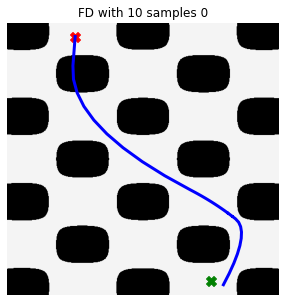

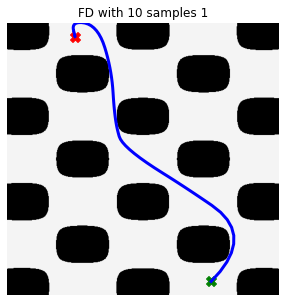

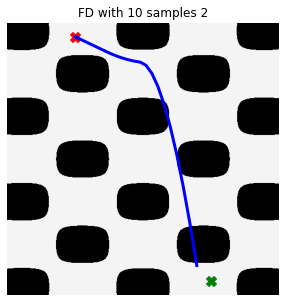

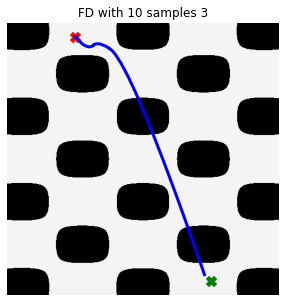

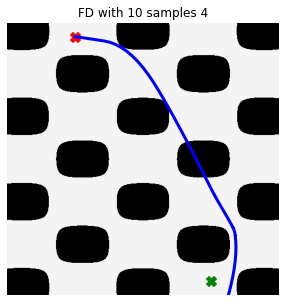

In [133]:
plt.figure(figsize=(10, 5))
for method in methods:
    for n in range(len(final_par[method])):
        if method == 'FD':
            if n != 1:
                continue
                label = 'FD1e-%d' % (n + 1)
            label = method
        else:
            label = method
        plt.plot(np.arange(max_iter) * final_par[method][n][2], final_par[method][n][1], label=label)
        
        print('time per iter for %s: %f' % (label, final_par[method][n][2]))
        
plt.xlim(-1, 50)
#plt.ylim(-1e4, 1e5)
plt.yscale('log')
plt.legend()
plt.title('optimization with nsamples = %d' % nsamples)
plt.show()

for method in methods:
    for n in range(len(final_par[method])):
        draw_path(final_par[method][n][0], pb, '%s with %d samples %d' % (method, nsamples, n))
        draw_path(final_par[method][n][0], pb, savename='%s_%d' % (method, n))

L0: 0.0
L1: 1.9239747728479638e-05
L2: 1.4891821609301782e-43
L3: 15.104719099789616
L sample: 15.104738339537345
15.104738339537345
[ 0.11007741  0.34251778  0.28376523  0.35329003  0.20802078  0.28335896
  0.30414344  0.47263323  0.3653749   0.35170249  0.43685739  0.33218805
  0.23857026  0.32363684  0.63512095  0.65146103  0.72285986  0.75261132
  0.15541405 -3.24673879  0.66152005  0.66999845  0.57445389  0.62522125
  1.03297119  0.49306466  1.10001756  1.28707104  1.28984374  3.18924014]


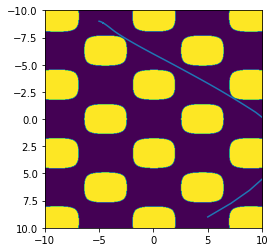

In [31]:
# FD 4
val = np.array([-0.09802253 , 0.29987501 , 0.12135904,  0.53392123, -0.41822451, -0.27426926,
  1.18851361,  0.97494758,  0.39383071,  2.60009848, -0.38099803, -0.09566422,
  1.25053302, -0.13121651,  0.03427106, -1.37200437,  0.33923339,  0.0603736,
  2.24186407,  8.03500792,  0.35835081,  0.99660772,  1.26228501 , 1.46309963,
  1.38575108,  1.5883066 ,  1.95292467,  1.15428556 , 0.67558286 , 1.14999108])

# FD 2
val = np.array([-0.16842668,  0.62955429, -0.58055009,  0.59688634 , 0.50537569 , 1.0008225,
  0.9532409  , 0.33294174, -0.08068258, -1.67039217,  0.25930609 , 0.71949226,
 -0.65091726, -0.02544315,  0.26236581, -0.0623131 , -0.13720451, -0.14282466,
  2.95244854,  3.84946268 , 1.68392373 , 1.09776368 , 1.75029254 , 3.23268591,
  0.61339153,  0.693096   , 1.08194126 , 1.50032325 , 0.6954236  , 1.47417586])

# ours 0
val = np.array([0.11007741 , 0.34251778 , 0.28376523 , 0.35329003 , 0.20802078 , 0.28335896,
  0.30414344 , 0.47263323 , 0.3653749 ,  0.35170249 , 0.43685739, 0.33218805,
  0.23857026 , 0.32363684,  0.63512095 , 0.65146103 , 0.72285986 , 0.75261132,
  0.15541405 ,-3.24673879 , 0.66152005 , 0.66999845 , 0.57445389 , 0.62522125,
  1.03297119 , 0.49306466 , 1.10001756 , 1.28707104 , 1.28984374 , 3.18924014])


print('L sample:', pb.get_loss(val, True, 'sample'))
print(data['ours']['S_func'](val))
print(val)
draw_path(val, pb)

In [112]:
print(opt.m)
print(opt.v)

[-351.10652183 -402.23923298 -130.25722648   87.20463939   66.13671269
   59.32630629   48.39324808   37.40549104   24.34764561   19.45962548
 1325.61290568 1187.79576324  371.02595321 -287.72230153 -214.66976834
 -192.56416021 -157.07705971 -121.41242107  -79.02860109  -63.16266647
  466.40196863 -256.0190119   -34.71862693 -105.77862405 -116.95973676
 -123.92951376  -89.12660137  -50.14112142    3.23115732  122.47356226]
[1.14474002e+10 7.98350599e+09 6.63250649e+09 8.14064657e+09
 4.08360787e+09 2.80681389e+09 1.65855706e+09 8.63638088e+08
 2.92722214e+08 5.60069064e+07 3.79751834e+10 2.91054668e+10
 2.38129893e+10 2.97401918e+10 1.56621564e+10 1.14020405e+10
 7.16462447e+09 3.88718078e+09 1.32379528e+09 2.14204538e+08
 1.25567681e+11 9.14689032e+08 1.05333934e+09 3.31930531e+09
 3.26991562e+09 4.81813038e+09 3.77566266e+09 2.21321904e+09
 9.47815879e+08 5.68676665e+07]
